# Librairies

In [279]:
import datetime
import folium
from folium.features import GeoJsonPopup   
from folium import Choropleth
import geopandas as gpd
from geopandas import sjoin
import holidays
import json
from math import pi
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors     
import matplotlib.cm as cm  
import numpy as np
import pandas as pd
import seaborn as sns
from shapely.geometry import Point
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
pd.set_option('display.max_columns', None) 
sns.set_style("white")
sns.despine()

<Figure size 640x480 with 0 Axes>

# Data wrangling

In [280]:
# Gathering data
LesAkt_df = pd.read_csv('LesAkt_240717-250717.csv', sep='~')
LesAkt_df

,Sigel,Benutzergruppe,Geschlecht,Alter,Verkehrzelle,PLZ,Ausweisgueltigkeit,zuletzt aktiv,Nationalitaet,Anzahl
0,462,1.0,W,52.0,16112.0,13187.0,20251104.0,20250620,DE,1
1,844,3.0,M,28.0,212.0,10551.0,20251015.0,20250106,NaN,1
2,983,1.0,M,57.0,16511.0,13156.0,20251106.0,20250704,DE,1
3,462,6.0,M,8.0,16614.0,13127.0,20260106.0,20250106,DE,1
4,462,1.0,W,39.0,16011.0,13187.0,20260722.0,20250707,DE,1
...,...,...,...,...,...,...,...,...,...,...
46112,OPAC,1.0,W,54.0,11023.0,10405.0,20260125.0,20250515,DE,1
46113,971,6.0,W,9.0,10741.0,10439.0,20250924.0,20250704,DE,1
46114,462,6.0,M,8.0,16122.0,13187.0,20260206.0,20250426,DE,1
46115,458,6.0,W,16.0,11621.0,10245.0,20250521.0,20240913,DE,1


In [281]:
# corriger le nom des colonnes
LesAkt_df = LesAkt_df.rename(columns={
    "Ausweisgueltigkeit": "Ausweisgültigkeit",
    "zuletzt aktiv": "zuletzt_aktiv",
    "Nationalitaet": "Nationalität"
})
LesAkt_df.head(3)

,Sigel,Benutzergruppe,Geschlecht,Alter,Verkehrzelle,PLZ,Ausweisgültigkeit,zuletzt_aktiv,Nationalität,Anzahl
0,462,1.0,W,52.0,16112.0,13187.0,20251104.0,20250620,DE,1
1,844,3.0,M,28.0,212.0,10551.0,20251015.0,20250106,NaN,1
2,983,1.0,M,57.0,16511.0,13156.0,20251106.0,20250704,DE,1


In [303]:
# Charger CSV
Alter_Geschlecht_df = pd.read_csv("Alter vs Geschlecht.csv", sep=';')

# Mettre la colonne Altersgruppe comme index
Alter_Geschlecht_df = Alter_Geschlecht_df.set_index("Altersgruppe")

# Harmoniser les labels si besoin (exemple : "65+" → "65 und mehr")
mapping = {
    "0 - 6": "0-6",
    "6-15": "6 - 15",
    "65+": "65 und mehr"
}
Alter_Geschlecht_df = Alter_Geschlecht_df.rename(index=mapping)

# Réindexer dans l'ordre défini par age_labels
Alter_Geschlecht_df = Alter_Geschlecht_df.reindex(age_labels, fill_value=0)


In [304]:
print(Alter_Geschlecht_df.head())
print(Alter_Geschlecht_df.index)

              Männlich  Weiblich
Altersgruppe                    
0-6              11656     11112
6 - 15           19396     18705
15 - 18           6367      5980
18 - 20           4031      3603
20 - 25          10622     10502
Index(['0-6', '6 - 15', '15 - 18', '18 - 20', '20 - 25', '25 - 30', '30 - 35',
       '35 - 40', '40 - 45', '45 - 60', '60 - 65', '65 und mehr'],
      dtype='object', name='Altersgruppe')


# Data cleaning

In [285]:
LesAkt_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46117 entries, 0 to 46116
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sigel              46106 non-null  object 
 1   Benutzergruppe     46116 non-null  float64
 2   Geschlecht         44882 non-null  object 
 3   Alter              44871 non-null  float64
 4   Verkehrzelle       39849 non-null  float64
 5   PLZ                46055 non-null  float64
 6   Ausweisgültigkeit  46116 non-null  float64
 7   zuletzt_aktiv      46117 non-null  int64  
 8   Nationalität       43249 non-null  object 
 9   Anzahl             46117 non-null  int64  
dtypes: float64(5), int64(2), object(3)
memory usage: 3.5+ MB


In [286]:
# conversion date en type datetime
LesAkt_df['Ausweisgültigkeit'] = (
    LesAkt_df['Ausweisgültigkeit']
    .astype('Int64')  # supprime le .0 tout en gérant les NaN
    .astype(str)      # en texte pour datetime
)

LesAkt_df['Ausweisgültigkeit'] = pd.to_datetime(
    LesAkt_df['Ausweisgültigkeit'],
    format='%Y%m%d',
    errors='coerce'
)

LesAkt_df['zuletzt_aktiv'] = (
    LesAkt_df['zuletzt_aktiv']
    .astype('Int64')  # supprime le .0 tout en gérant les NaN
    .astype(str)      # en texte pour datetime
)

LesAkt_df['zuletzt_aktiv'] = pd.to_datetime(
    LesAkt_df['zuletzt_aktiv'],
    format='%Y%m%d',
    errors='coerce'
)

In [287]:
# Datatype str pour Mediennummer
LesAkt_df["Verkehrzelle"] = (
    LesAkt_df["Verkehrzelle"]
    .astype(float)  # au cas où il y ait encore du float
    .astype("Int64") # Pandas integer nullable
    .astype(str)    # en texte, pour éviter le .0
)

LesAkt_df["PLZ"] = (
    LesAkt_df["PLZ"]
    .astype(float)  # au cas où il y ait encore du float
    .astype("Int64") # Pandas integer nullable
    .astype(str)    # en texte, pour éviter le .0
)

LesAkt_df["Benutzergruppe"] = (
    LesAkt_df["Benutzergruppe"]
    .astype(float)  # au cas où il y ait encore du float
    .astype("Int64") # Pandas integer nullable
    .astype(str)    # en texte, pour éviter le .0
)

In [288]:
# data types conversion
LesAkt_df.astype({
    'Alter': 'Int64'
}).dtypes
LesAkt_df = LesAkt_df.astype({
    'Alter': 'Int64'
})
LesAkt_df.dtypes

Sigel                        object
Benutzergruppe               object
Geschlecht                   object
Alter                         Int64
Verkehrzelle                 object
PLZ                          object
Ausweisgültigkeit    datetime64[ns]
zuletzt_aktiv        datetime64[ns]
Nationalität                 object
Anzahl                        int64
dtype: object

In [289]:
#test null values
print(LesAkt_df.isnull().sum())

Sigel                  11
Benutzergruppe          0
Geschlecht           1235
Alter                1246
Verkehrzelle            0
PLZ                     0
Ausweisgültigkeit       1
zuletzt_aktiv           0
Nationalität         2868
Anzahl                  0
dtype: int64


In [290]:
# delete null values
LesAkt_df.dropna(subset=['Sigel'], inplace=True)
LesAkt_df.dropna(subset=['Benutzergruppe'], inplace=True)
LesAkt_df.dropna(subset=['Geschlecht'], inplace=True)
LesAkt_df.dropna(subset=['Alter'], inplace=True)
LesAkt_df.dropna(subset=['Ausweisgültigkeit'], inplace=True)
LesAkt_df.dropna(subset=['Nationalität'], inplace=True)
print(LesAkt_df.isnull().sum())


Sigel                0
Benutzergruppe       0
Geschlecht           0
Alter                0
Verkehrzelle         0
PLZ                  0
Ausweisgültigkeit    0
zuletzt_aktiv        0
Nationalität         0
Anzahl               0
dtype: int64


In [291]:
# test duplicate
duplicate_rows = LesAkt_df.duplicated().sum()
print(duplicate_rows)
# Pas de doublons.

0


In [292]:
# comptabiliser les valeurs uniques
LesAkt_df.nunique()

Sigel                 137
Benutzergruppe         10
Geschlecht              3
Alter                  99
Verkehrzelle          938
PLZ                   626
Ausweisgültigkeit    1473
zuletzt_aktiv         348
Nationalität          125
Anzahl                  5
dtype: int64

In [293]:
LesAkt_df

,Sigel,Benutzergruppe,Geschlecht,Alter,Verkehrzelle,PLZ,Ausweisgültigkeit,zuletzt_aktiv,Nationalität,Anzahl
0,462,1,W,52,16112,13187,2025-11-04,2025-06-20,DE,1
2,983,1,M,57,16511,13156,2025-11-06,2025-07-04,DE,1
3,462,6,M,8,16614,13127,2026-01-06,2025-01-06,DE,1
4,462,1,W,39,16011,13187,2026-07-22,2025-07-07,DE,1
5,650,1,W,74,15615,13129,2026-05-19,2025-06-16,DE,1
...,...,...,...,...,...,...,...,...,...,...
46112,OPAC,1,W,54,11023,10405,2026-01-25,2025-05-15,DE,1
46113,971,6,W,9,10741,10439,2025-09-24,2025-07-04,DE,1
46114,462,6,M,8,16122,13187,2026-02-06,2025-04-26,DE,1
46115,458,6,W,16,11621,10245,2025-05-21,2024-09-13,DE,1


In [294]:
LesAkt_df.shape
# ancien contenu LesAkt_df = 46.117 rows × 10 columns
# nouveau contenu LesAkt_df = 43.220.388 rows x 10 columns

(43220, 10)

In [295]:
LesAkt_df.describe()

,Alter,Ausweisgültigkeit,zuletzt_aktiv,Anzahl
count,43220.0,43220,43220,43220.000000
mean,30.882878,2025-10-07 21:28:26.210087680,2025-03-26 21:15:38.565479168,1.004142
min,0.0,1993-02-28 00:00:00,2024-07-17 00:00:00,1.000000
25%,10.0,2025-09-03 00:00:00,2025-01-10 00:00:00,1.000000
50%,30.0,2025-11-27 00:00:00,2025-05-02 00:00:00,1.000000
75%,47.0,2026-03-10 00:00:00,2025-06-27 00:00:00,1.000000
max,98.0,2045-10-30 00:00:00,2025-07-17 00:00:00,15.000000
std,21.823165,NaN,NaN,0.097904


# Exploratory Data Analysis (EDA) 

Benutzergruppe         10
Geschlecht              3
Alter                  99
Nationalität          125

In [296]:
# Age pyramid
print(LesAkt_df["Geschlecht"].value_counts(dropna=False))

Geschlecht
W    26436
M    16647
K      137
Name: count, dtype: int64


In [297]:
Alter_Geschlecht_df

,Altersgruppe,Männlich,Weiblich
0,0-6,11656,11112
1,6 - 15,19396,18705
2,15 - 18,6367,5980
3,18 - 20,4031,3603
4,20 - 25,10622,10502
5,25 - 30,14012,15202
6,30 - 35,17557,18410
7,35 - 40,20117,20808
8,40 - 45,18118,18555
9,45 - 60,47637,45968


Pyramide des âges

/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_3119/1919932672.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_pyramid_global = LesAkt_df.groupby(['Altersgruppe', 'Geschlecht']).size().unstack(fill_value=0)
/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_3119/1919932672.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([abs(int(x)) for x in ax.get_xticks()])
/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_3119/1919932672.py:52: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([abs(int(x)) for x in ax2.get_xticks()])


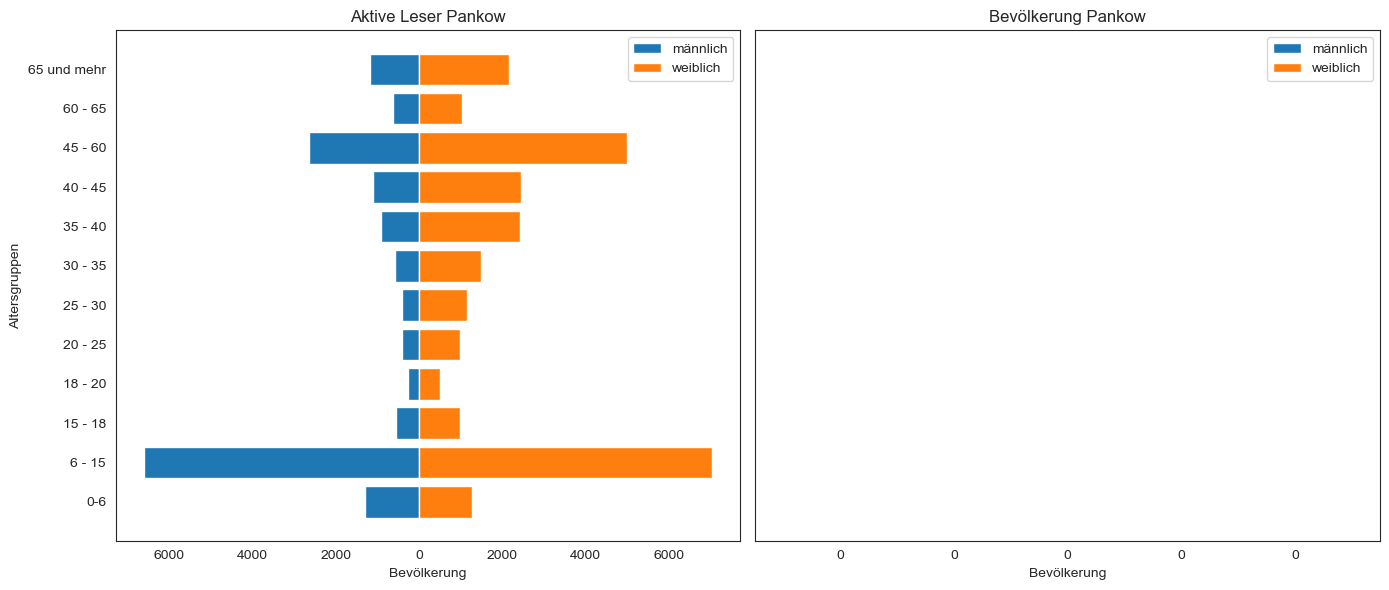

In [298]:

# Définir les tranches d'âge
age_labels = ['0-6', '6 - 15', '15 - 18', '18 - 20', '20 - 25', 
              '25 - 30', '30 - 35', '35 - 40', '40 - 45', '45 - 60', 
              '60 - 65', '65 und mehr']

# ---------------------------
# 1️⃣ Pyramide globale
# ---------------------------
# Catégoriser les âges avec les mêmes groupes que Pankow
LesAkt_df['Altersgruppe'] = pd.cut(
    LesAkt_df['Alter'],
    bins=[0,6,15,18,20,25,30,35,40,45,60,65,200],
    labels=age_labels,
    right=False
)

# Grouper et remplir les valeurs manquantes avec 0
age_pyramid_global = LesAkt_df.groupby(['Altersgruppe', 'Geschlecht']).size().unstack(fill_value=0)

# S'assurer que toutes les tranches sont présentes
age_pyramid_global = age_pyramid_global.reindex(age_labels, fill_value=0)

# ---------------------------
# 2️⃣ Pyramide Pankow
# ---------------------------
# L'index est déjà Altersgruppe, on réindex juste pour être sûr de l'ordre
Alter_Geschlecht_df = Alter_Geschlecht_df.reindex(age_labels, fill_value=0)

# ---------------------------
# 3️⃣ Création du subplot
# ---------------------------
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)


# 🔹 Pyramide globale
ax = axes[0]
ax.barh(age_pyramid_global.index, -age_pyramid_global.get('M',0), label='männlich')
ax.barh(age_pyramid_global.index,  age_pyramid_global.get('W',0), label='weiblich')
ax.set_xlabel("Bevölkerung")
ax.set_ylabel("Altersgruppen")
ax.set_title("Aktive Leser Pankow")
ax.legend()
ax.set_xticklabels([abs(int(x)) for x in ax.get_xticks()])

# 🔹 Pyramide Pankow
ax2 = axes[1]
ax2.barh(Alter_Geschlecht_df.index, -Alter_Geschlecht_df['Männlich'], label='männlich')
ax2.barh(Alter_Geschlecht_df.index,  Alter_Geschlecht_df['Weiblich'], label='weiblich')
ax2.set_xlabel("Bevölkerung")
ax2.set_title("Bevölkerung Pankow")
ax2.legend()
ax2.set_xticklabels([abs(int(x)) for x in ax2.get_xticks()])


plt.tight_layout()
plt.show()


/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_3119/2239439010.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  LesAkt_df.groupby(['Altersgruppe', 'Geschlecht'])
/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_3119/2239439010.py:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([abs(int(x)) for x in ax.get_xticks()])
/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_3119/2239439010.py:79: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([abs(int(x)) for x in ax2.get_xticks()])


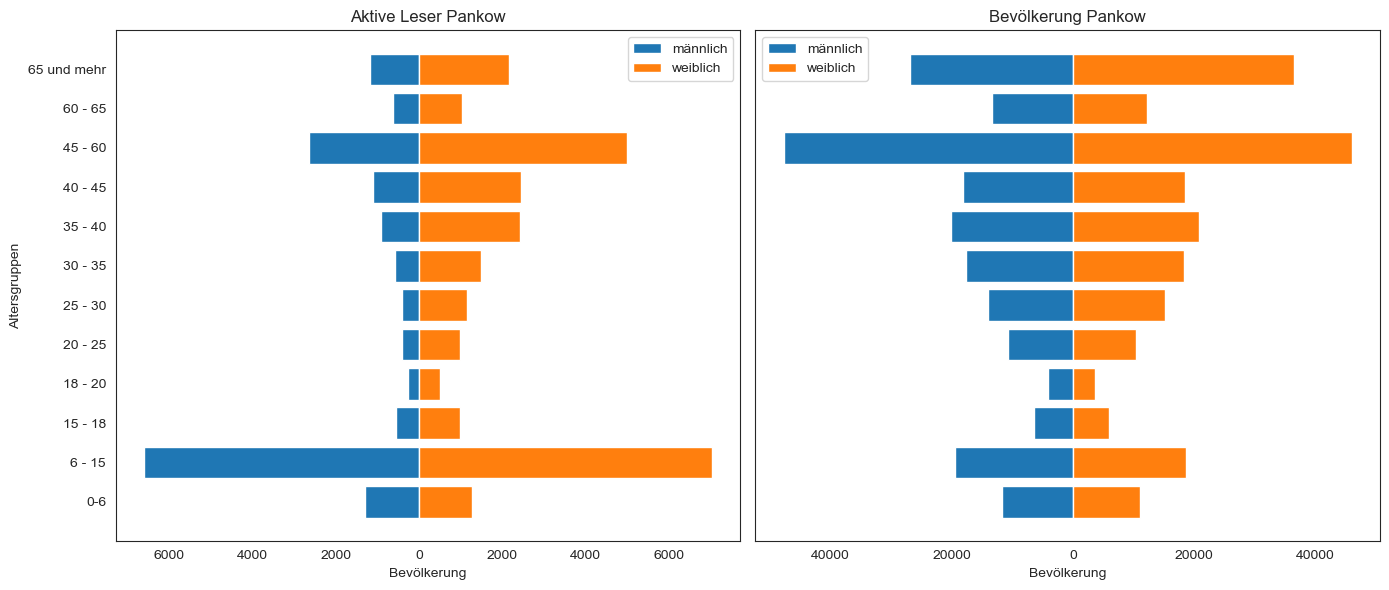

In [305]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 0️⃣ Définir les tranches d'âge
# ---------------------------
age_labels = ['0-6', '6 - 15', '15 - 18', '18 - 20', '20 - 25', 
              '25 - 30', '30 - 35', '35 - 40', '40 - 45', '45 - 60', 
              '60 - 65', '65 und mehr']

# ---------------------------
# 1️⃣ Pyramide globale (lecteurs actifs)
# ---------------------------
LesAkt_df['Altersgruppe'] = pd.cut(
    LesAkt_df['Alter'],
    bins=[0,6,15,18,20,25,30,35,40,45,60,65,200],
    labels=age_labels,
    right=False
)

age_pyramid_global = (
    LesAkt_df.groupby(['Altersgruppe', 'Geschlecht'])
    .size()
    .unstack(fill_value=0)
    .reindex(age_labels, fill_value=0)
)

# Harmoniser noms de colonnes
col_map = {'M': 'Männlich', 'W': 'Weiblich'}
age_pyramid_global = age_pyramid_global.rename(columns=col_map)

# Supprimer colonne 'K' si présente
if 'K' in age_pyramid_global.columns:
    age_pyramid_global = age_pyramid_global.drop(columns=['K'])

# ---------------------------
# 2️⃣ Pyramide Pankow (population)
# ---------------------------
# Charger CSV
Alter_Geschlecht_df = pd.read_csv("Alter vs Geschlecht.csv", sep=';')

# Mettre Altersgruppe en index
if "Altersgruppe" in Alter_Geschlecht_df.columns:
    Alter_Geschlecht_df = Alter_Geschlecht_df.set_index("Altersgruppe")

# Harmoniser éventuels labels différents
mapping = {
    "0 - 6": "0-6",
    "6-15": "6 - 15",
    "65+": "65 und mehr"
}
Alter_Geschlecht_df = Alter_Geschlecht_df.rename(index=mapping)

# Réindexer dans le bon ordre
Alter_Geschlecht_df = Alter_Geschlecht_df.reindex(age_labels, fill_value=0)

# ---------------------------
# 3️⃣ Création du subplot
# ---------------------------
fig, axes = plt.subplots(ncols=2, figsize=(14, 6), sharey=True)

# 🔹 Pyramide globale
ax = axes[0]
ax.barh(age_pyramid_global.index, -age_pyramid_global['Männlich'], label='männlich')
ax.barh(age_pyramid_global.index,  age_pyramid_global['Weiblich'], label='weiblich')
ax.set_xlabel("Bevölkerung")
ax.set_ylabel("Altersgruppen")
ax.set_title("Aktive Leser Pankow")
ax.legend()
ax.set_xticklabels([abs(int(x)) for x in ax.get_xticks()])

# 🔹 Pyramide Pankow
ax2 = axes[1]
ax2.barh(Alter_Geschlecht_df.index, -Alter_Geschlecht_df['Männlich'], label='männlich')
ax2.barh(Alter_Geschlecht_df.index,  Alter_Geschlecht_df['Weiblich'], label='weiblich')
ax2.set_xlabel("Bevölkerung")
ax2.set_title("Bevölkerung Pankow")
ax2.legend()
ax2.set_xticklabels([abs(int(x)) for x in ax2.get_xticks()])

plt.tight_layout()
plt.show()


Analyse: disproportion enfant/adulte et homme/femme

/var/folders/_w/syp13sn960j6v43pwrmhdn2r0000gp/T/ipykernel_3119/1793924048.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  akt_counts = LesAkt_df.groupby(['Altersgruppe','Geschlecht']).size().reset_index(name="Aktive_Nutzer")


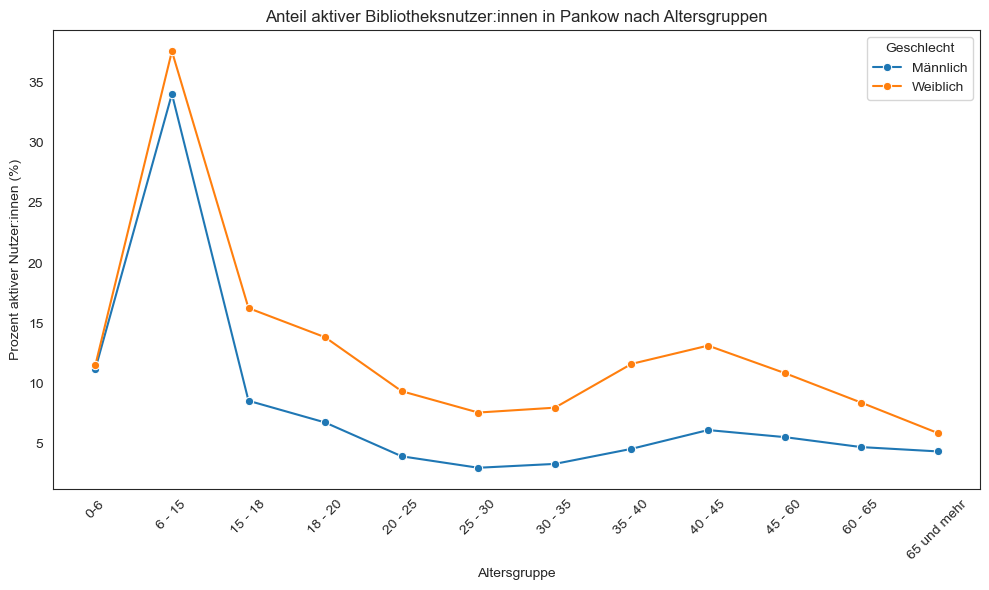

In [306]:
# ---------------------------
# 1️⃣ Catégoriser les âges des usagers actifs
# ---------------------------
age_labels = ['0-6', '6 - 15', '15 - 18', '18 - 20', '20 - 25', 
              '25 - 30', '30 - 35', '35 - 40', '40 - 45', '45 - 60', 
              '60 - 65', '65 und mehr']

LesAkt_df['Altersgruppe'] = pd.cut(
    LesAkt_df['Alter'],
    bins=[0,6,15,18,20,25,30,35,40,45,60,65,200],
    labels=age_labels,
    right=False
)

# ---------------------------
# 2️⃣ Compter les usagers actifs par tranche et sexe
# ---------------------------
akt_counts = LesAkt_df.groupby(['Altersgruppe','Geschlecht']).size().reset_index(name="Aktive_Nutzer")

# Harmoniser Geschlecht : M → Männlich, W → Weiblich
geschlecht_map = {"M": "Männlich", "W": "Weiblich"}
akt_counts['Geschlecht'] = akt_counts['Geschlecht'].map(geschlecht_map)
# S'assurer que l'index est bien une colonne
Alter_Geschlecht_df = Alter_Geschlecht_df.reset_index().rename(columns={"index": "Altersgruppe"})

# Maintenant on peut passer en long format
pop_long = Alter_Geschlecht_df.melt(
    id_vars="Altersgruppe",
    value_vars=["Männlich", "Weiblich"],
    var_name="Geschlecht",
    value_name="Bevölkerung"
)

# ---------------------------
# 4️⃣ Fusionner population + actifs
# ---------------------------
merged_df = pd.merge(
    pop_long,
    akt_counts,
    on=["Altersgruppe","Geschlecht"],
    how="left"
).fillna(0)

# ---------------------------
# 5️⃣ Calcul du pourcentage
# ---------------------------
merged_df["Prozent_aktiv"] = merged_df["Aktive_Nutzer"] / merged_df["Bevölkerung"] * 100

# ---------------------------
# 6️⃣ Visualisation
# ---------------------------
plt.figure(figsize=(10,6))
sns.lineplot(
    data=merged_df,
    x="Altersgruppe",
    y="Prozent_aktiv",
    hue="Geschlecht",
    marker="o"
)

plt.title("Anteil aktiver Bibliotheksnutzer:innen in Pankow nach Altersgruppen")
plt.xlabel("Altersgruppe")
plt.ylabel("Prozent aktiver Nutzer:innen (%)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Mapping

In [310]:
LesAkt_df

,Sigel,Benutzergruppe,Geschlecht,Alter,Verkehrzelle,PLZ,Ausweisgültigkeit,zuletzt_aktiv,Nationalität,Anzahl,Altersgruppe
0,462,1,W,52,16112,13187,2025-11-04,2025-06-20,DE,1,45 - 60
2,983,1,M,57,16511,13156,2025-11-06,2025-07-04,DE,1,45 - 60
3,462,6,M,8,16614,13127,2026-01-06,2025-01-06,DE,1,6 - 15
4,462,1,W,39,16011,13187,2026-07-22,2025-07-07,DE,1,35 - 40
5,650,1,W,74,15615,13129,2026-05-19,2025-06-16,DE,1,65 und mehr
...,...,...,...,...,...,...,...,...,...,...,...
46112,OPAC,1,W,54,11023,10405,2026-01-25,2025-05-15,DE,1,45 - 60
46113,971,6,W,9,10741,10439,2025-09-24,2025-07-04,DE,1,6 - 15
46114,462,6,M,8,16122,13187,2026-02-06,2025-04-26,DE,1,6 - 15
46115,458,6,W,16,11621,10245,2025-05-21,2024-09-13,DE,1,15 - 18


In [311]:
verkehrzelle_df = gpd.read_file("teil_verkehrszellen.geojson")
verkehrzelle_df

,gml_id,spatial_name,spatial_alias,spatial_type,CODE,NAME,TYPENO,I_BLN_BZ,I_VZ_NR,SCHLUESSEL,B_NEUE_NR,I_LOR_PRR,I_VBZ122_1,TVZ_881,VBZ_1193,VBZ_TYP_2,VBZ_TYP_3,VBZ_TYP_NO,geometry
0,re_vkz_teil.110100111,110100111,110100111,Polygon,00111,Wiebestraße / Huttenstraße,2,1,0011,0,1,102,110100112,112,110100112,HK,großer Hundekopf (mit Typ 1 & 2 & 3),4,"POLYGON ((13.32467 52.53087, 13.32465 52.53214..."
1,re_vkz_teil.110100121,110100121,110100121,Polygon,00121,An der Putlitzbrücke / Friedrich-Krause-Ufer,3,1,0012,0,0,102,110100121,121,110100121,RestB,Berlin (außerhalb großer Hundekopf),5,"POLYGON ((13.34487 52.53857, 13.34476 52.53847..."
2,re_vkz_teil.110100122,110100122,110100122,Polygon,00122,Großmarkt Beusselstraße,3,1,0012,0,1,102,110100111,111,110100111,RestB,Berlin (außerhalb großer Hundekopf),5,"POLYGON ((13.31751 52.53238, 13.31788 52.53243..."
3,re_vkz_teil.110100123,110100123,110100123,Polygon,00123,Seestraße / Föhrer Brücke (Föhrer Straße),3,1,0012,0,0,102,110100123,121,110100123,RestB,Berlin (außerhalb großer Hundekopf),5,"POLYGON ((13.34487 52.53857, 13.34511 52.53888..."
4,re_vkz_teil.110100124,110100124,110100124,Polygon,00124,An der Putlitzbrücke / Westhafenstraße,3,1,0012,0,0,102,110100124,121,110100123,RestB,Berlin (außerhalb großer Hundekopf),5,"POLYGON ((13.34487 52.53857, 13.34444 52.53863..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1218,re_vkz_teil.111209643,111209643,111209643,Polygon,09643,Roedernallee / Tessenowstraße,3,12,0964,0,0,1230,111209643,9643,111209643,RestB,Berlin (außerhalb großer Hundekopf),5,"POLYGON ((13.346 52.59078, 13.34595 52.59055, ..."
1219,re_vkz_teil.111209644,111209644,111209644,Polygon,09644,Techowpromenade / Alt-Wittenau,3,12,0964,0,0,1230,111209644,9644,111209644,RestB,Berlin (außerhalb großer Hundekopf),5,"POLYGON ((13.32753 52.59325, 13.32654 52.59217..."
1220,re_vkz_teil.111209645,111209645,111209645,Polygon,09645,Oranienburger Straße / Roedernallee,3,12,0964,0,0,1230,111209645,9644,111209645,RestB,Berlin (außerhalb großer Hundekopf),5,"POLYGON ((13.346 52.59078, 13.34567 52.59096, ..."
1221,re_vkz_teil.111209711,111209711,111209711,Polygon,09711,Holzhauserstraße / Miraustraße,3,12,0971,0,0,1230,111209711,9711,111209711,RestB,Berlin (außerhalb großer Hundekopf),5,"POLYGON ((13.32364 52.58738, 13.32396 52.58779..."


# The end